Get TopicTuner from github

In [2]:
!git clone  https://github.com/drob-xx/TopicTuner.git

fatal: destination path 'TopicTuner' already exists and is not an empty directory.


In [5]:
print(sys.path)

['c:\\Users\\Administrator\\Repositories\\HateRecognition\\target_model', 'c:\\Users\\Administrator\\.conda\\envs\\py310\\python310.zip', 'c:\\Users\\Administrator\\.conda\\envs\\py310\\DLLs', 'c:\\Users\\Administrator\\.conda\\envs\\py310\\lib', 'c:\\Users\\Administrator\\.conda\\envs\\py310', '', 'c:\\Users\\Administrator\\.conda\\envs\\py310\\lib\\site-packages', 'c:\\Users\\Administrator\\.conda\\envs\\py310\\lib\\site-packages\\win32', 'c:\\Users\\Administrator\\.conda\\envs\\py310\\lib\\site-packages\\win32\\lib', 'c:\\Users\\Administrator\\.conda\\envs\\py310\\lib\\site-packages\\Pythonwin']


Place TopicTuner on the path

In [1]:
from TopicTuner.topictuner import TopicModelTuner as TMT
# from TopicTuner.topictuner import TopicModelTuner as TMT
import sys
sys.path.append("./HateRecognition/")
from target_model.utils import load_anno_data
import pandas as pd
from collections import Counter


Get 20NewsGroup data

Create a TMT instance from scratch

In [2]:
df = pd.read_csv(r'./HateRecognition/data/annotated_target_topic_data.csv')
hate_df = df[df['label']=='hatespeech']
# docs = [' '.join(x) for x in df.tokens.values]
# hate_df = hate_df[hate_df['target'].isin({'Asian', 'Other', 'None', 'Women', 'Hispanic'})]
hate_df.loc[hate_df['target']=='Arab','target'] = 'Islam'
labels_counter = Counter(hate_df.target.tolist())
hate_df = hate_df[hate_df['target'].isin(x[0] for x in labels_counter.most_common(4))]


In [10]:
hate_df.target.unique()

array(['Jewish', 'African', 'Islam', 'Homosexual'], dtype=object)

Alternatively, you can create one from an existing BERTopic instance by calling 

newTMT = TMT.wrapBERTopicModel(<your BERTopic model>)

Create the embeddings.

In [3]:
tmt = TMT()
docs = list(hate_df.text.values)
tmt.createEmbeddings(docs)

Then reduce them to 5 features ala BERTopic byt calling TMT.reduce()

In [4]:
tmt.reduce()

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=5, n_neighbors=5, verbose=2)
Tue Jan 24 10:53:46 2023 Construct fuzzy simplicial set
Tue Jan 24 10:53:46 2023 Finding Nearest Neighbors
Tue Jan 24 10:53:46 2023 Building RP forest with 9 trees
Tue Jan 24 10:53:46 2023 NN descent for 12 iterations
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	 6  /  12
	 7  /  12
	Stopping threshold met -- exiting after 7 iterations
Tue Jan 24 10:54:26 2023 Finished Nearest Neighbor Search
Tue Jan 24 10:54:29 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Tue Jan 24 10:54:38 2023 Finished embedding


Now we can explore different HDBSCAN settings for this instance of the UMAP reductions.

TMT.randomSearch takes two arrays as arguments. By default it will execute 20 searches, randomly selecting the values passed in the first array as the min_cluster_size. The decimal float values in the second array will be randomly selected and then multiplied with the selected min_cluster_size to determine a sample_size.

Note that the values for in each of these search examples below will likely have to be modified to give you optimized results for your specific UMAP reduction.

In [13]:
lastRunResultsDF = tmt.randomSearch([*range(300,600)], [.1, .25, .5, .75, 1], 40)

  0%|          | 0/40 [00:00<?, ?it/s]

Each time a TMT search is performed all the results are collected in the TMT.ResultsDF DataFrame. Each search returns a DataFrame with just the results of that search.

TMT.visualizeSearch produces a plotly parallel coordinates graph. You can pass it TMT.ResultsDF to get a view of all the searches, or pass it the results from a particular search.

In [14]:
tmt.visualizeSearch(lastRunResultsDF).show()

TMT.summarizeResults sorts a results table by number_of_cluster and selects the 'best' value for that number of clusters by choosing the one with the least uncategorized results.

In [15]:
tmt.summarizeResults(lastRunResultsDF).sort_values(by=['number_uncategorized'])

min_cluster_size  sample_size  number_of_clusters  number_uncategorized
0               507           50                   4                    52
1               328           32                   5                    74

In [16]:
best_range = range(328,331)

TMT.gridSearch() is suitable once you have narrowed down the ranges. It will search ALL the min_cluster_size values passed with each of the percentage values being evaluated to the given sample_size value. In the example below 15 runs will be performed - five different sample_sizes for each of the three min_cluster_size values - 131, 132, 133.

In [17]:
lastRunResultsDF = tmt.gridSearch([*best_range], [.1, .25, .5, .75, 1])

  0%|          | 0/15 [00:00<?, ?it/s]

In [18]:
tmt.summarizeResults(lastRunResultsDF).sort_values(by=['number_uncategorized'])

min_cluster_size  sample_size  number_of_clusters  number_uncategorized
0               328           32                   5                    74

Once you have narrowed down the values of interest further you may want to run a more thorough search to do this. TMT.simpleSearch takes two arrays as arguments. The first are the min_cluster_sizes and the second are the sample_sizes. You might prepare these lists like this:

In [19]:
csizes = []
ssizes = []
for csize in [*best_range] :
  for ssize in range(1, csize+1) :
    csizes.append(csize)
    ssizes.append(ssize)

In the above example csizes is a list of 131 values of 131. ssizes is 131 values of 1 to 131. This runs ALL possible sample sizes (131) for the min_cluster_size of 131. The first run will be min_cluster_size=131, sample_size=1, the second min_cluster_size=131, sample_size=2 etc.

In [20]:
lastRunResultsDF = tmt.simpleSearch(csizes, ssizes)

  0%|          | 0/987 [00:00<?, ?it/s]

TMT can generate a scatterplot of your embeddings overlayed with the clustering of a given set of parameters. This can assist in deciding how many clusters to select for your model.

To accomplish this, first you must create a 2D reduction of the embeddings suitable for a 2D scatterplot.

In [7]:
tmt.createVizReduction()

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_neighbors=5, verbose=2)
Tue Jan 24 10:54:54 2023 Construct fuzzy simplicial set
Tue Jan 24 10:54:54 2023 Finding Nearest Neighbors
Tue Jan 24 10:54:54 2023 Building RP forest with 9 trees
Tue Jan 24 10:54:54 2023 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	 6  /  12
	 7  /  12
	 8  /  12
	Stopping threshold met -- exiting after 8 iterations
Tue Jan 24 10:54:54 2023 Finished Nearest Neighbor Search
Tue Jan 24 10:54:54 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Tue Jan 24 10:55:04 2023 Finished embedding


In [22]:
lastRunResultsDF.sort_values(by=['number_uncategorized'])

min_cluster_size  sample_size  number_of_clusters  number_uncategorized
684               330           28                   5                    25
27                328           28                   5                    25
676               330           20                   5                    25
347               329           20                   5                    25
19                328           20                   5                    25
..                ...          ...                 ...                   ...
983               330          327                   5                   514
984               330          328                   5                   515
327               328          328                   5                   515
655               329          328                   5                   515
986               330          330                   5                   517

[987 rows x 4 columns]

In [5]:
best_params = (330,28)

If TMT has access to the docs it will use them to add document text to the scatterplot.

In [8]:
tmt.visualizeEmbeddings(*best_params).show()

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(stop_words="english")
bt = tmt.getBERTopicModel(*best_params)
bt.vectorizer_model=vectorizer_model
bt.umap_model = tmt.reducer_model
topics = bt.fit_transform(docs)


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=5, n_neighbors=5, verbose=2)
Tue Jan 24 10:56:28 2023 Construct fuzzy simplicial set
Tue Jan 24 10:56:28 2023 Finding Nearest Neighbors
Tue Jan 24 10:56:28 2023 Building RP forest with 9 trees
Tue Jan 24 10:56:28 2023 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	 6  /  12
	 7  /  12
	 8  /  12
	Stopping threshold met -- exiting after 8 iterations
Tue Jan 24 10:56:28 2023 Finished Nearest Neighbor Search
Tue Jan 24 10:56:28 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Tue Jan 24 10:56:37 2023 Finished embedding


In [27]:
bt.transform(['I hate jews'])

Tue Jan 17 14:54:35 2023 Worst tree score: 0.20575179
Tue Jan 17 14:54:35 2023 Mean tree score: 0.20875421
Tue Jan 17 14:54:35 2023 Best tree score: 0.21270025
Tue Jan 17 14:54:38 2023 Forward diversification reduced edges from 25905 to 16623
Tue Jan 17 14:54:42 2023 Reverse diversification reduced edges from 16623 to 16623
Tue Jan 17 14:54:44 2023 Degree pruning reduced edges from 18254 to 17607
Tue Jan 17 14:54:44 2023 Resorting data and graph based on tree order
Tue Jan 17 14:54:44 2023 Building and compiling search function


Epochs completed:   0%|            0/100 [00:00]

([2], array([1.]))

In [10]:
bt.get_topic_info()

Topic  Count                             Name
0      0   1781    0_nigger_niggers_white_number
1      1   1432            1_kike_jews_jew_white
2      2   1405      2_moslem_sand_muslim_number
3      3    399    3_faggots_faggot_queers_dykes
4     -1    164  -1_mudshark_user_nigger_raghead

In [29]:
hate_df['topics'] = [bt.topic_names[x] for x in topics[0]]

In [30]:
target_labels = {'Jewish':1, 'African':0, 'Islam':2, 'Homosexual':3}
hate_df['encoded_target'] = [target_labels[x] for x in hate_df['target'].values]
hate_df['encoded_topics'] = topics[0]

In [35]:
g_hate_df = hate_df.groupby(['topics', 'target']).count()['label'].reset_index()
p_g_hate_df = g_hate_df.pivot_table(columns=g_hate_df.topics, index=g_hate_df.target)
p_g_hate_df.columns = p_g_hate_df.columns.droplevel(0)
p_g_hate_df = p_g_hate_df.reindex(['African','Islam' ,'Jewish' , 'Homosexual'])
n_p_g_hate_df = p_g_hate_df.apply(lambda x: x/x.sum(), axis=1).drop(columns=['-1_coons_nigger_coon_towel'])


<AxesSubplot:xlabel='topics', ylabel='target'>

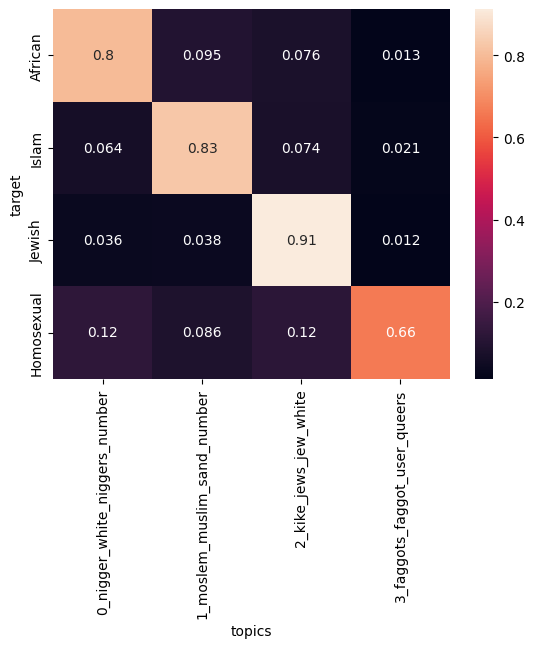

In [36]:
import seaborn as sns
sns.heatmap(n_p_g_hate_df, annot=True)

In [14]:
bt.save('./topic_model')

In [38]:
bt.visualize_barchart()

You can save your TMT model with TMT.save()

You can save your TMT model with TMT.save()

In [37]:
tmt.save('topic_model')

Tue Jan 17 15:00:38 2023 Worst tree score: 0.20015441
Tue Jan 17 15:00:38 2023 Mean tree score: 0.20931180
Tue Jan 17 15:00:38 2023 Best tree score: 0.22080679
Tue Jan 17 15:00:38 2023 Forward diversification reduced edges from 25905 to 16658
Tue Jan 17 15:00:38 2023 Reverse diversification reduced edges from 16658 to 16658
Tue Jan 17 15:00:38 2023 Degree pruning reduced edges from 18396 to 17702
Tue Jan 17 15:00:38 2023 Resorting data and graph based on tree order
Tue Jan 17 15:00:38 2023 Building and compiling search function


And restore it using TMT.load()

In [3]:
tmt2 = TMT.load('temp')

Sun Jan  8 22:05:26 2023 Building and compiling search function
Sun Jan  8 22:05:29 2023 Building and compiling search function


Once you have determined parameters that work for your text, TMT can manufacture a BERTopic model. Note in this example we pass BERTopic the embeddings created earlier - no need to have BERTopic re-run them.

In [5]:
bt1.save('bert_model')

In [100]:
topic2label = {'0_nigger_the_to_and':'African', '1_kike_the_jews_to':'Jewish','2_the_to_and_of':'?','-1_islam_the_and_to':'Islam', '3_the_you_to_user':'?'}

In [41]:
df.to_csv('../data/annotated_target_topic_data.csv')

In [103]:
hate_df['topic_target'] = hate_df['topics'].apply(lambda x: topic2label[x])

In [113]:
(hate_df['target'] == hate_df['topic_target']).sum()/len(hate_df)

0.48684632659608595